# Group 3: Influential Superspreader Detection

In [34]:
# --- 1. Imports and Settings ---
import pandas as pd
import numpy as np
import networkx as nx
from datetime import timedelta
import matplotlib.pyplot as plt

# Settings
DATA_PATH = './COVID19.csv'  # adjust if needed
NEWSGUARD_THRESHOLD = 39  # low-credibility threshold
DELTA_DAYS = 3          # time slot length
ALPHA = 0.5              # EMA smoothing factor

In [35]:
# --- 2. Load and Preprocess Data ---
df = pd.read_csv(DATA_PATH, parse_dates=['created_at'])

# Filter for low-credibility content
df = df[df['credibility_score'] <= NEWSGUARD_THRESHOLD]
# Remove self-reposts
df = df[df['user_id'] != df['retweeted_user_id']]

df.head()

,tweet_id,created_at,user_id,retweeted_status_id,retweeted_user_id,credibility_score
2,1333562964566282241,2020-12-01 00:06:01+00:00,717318358803283968,1333409142262915074,1.032616e+09,5.0
3,1333562964566282241,2020-12-01 00:06:01+00:00,717318358803283968,1333409142262915074,1.032616e+09,5.0
4,1333562964566282241,2020-12-01 00:06:01+00:00,717318358803283968,1333409142262915074,1.032616e+09,5.0
5,1333566558665396224,2020-12-01 00:20:18+00:00,2195968707,1333474367284666375,1.683455e+09,5.0
6,1333566558665396224,2020-12-01 00:20:18+00:00,2195968707,1333474367284666375,1.683455e+09,5.0


In [36]:
# --- 3. Compute Influential Metric per User per Time Slot ---
def compute_influential_by_slot(df, start_date, end_date, delta):
    """
    Partition the data into time slots of length `delta` days and compute
    total re-posts per user in each slot.
    """
    slots = {}
    current_start = start_date
    slot_idx = 0
    while current_start < end_date:
        current_end = current_start + timedelta(days=delta)
        mask = (df['created_at'] >= current_start) & (df['created_at'] < current_end)
        sub = df[mask]
        counts = sub.groupby('retweeted_user_id').size()
        slots[slot_idx] = counts
        slot_idx += 1
        current_start = current_end
    return slots

min_date, max_date = df['created_at'].min(), df['created_at'].max()
slots = compute_influential_by_slot(df, min_date, max_date, DELTA_DAYS)
slots

{0: retweeted_user_id
 5.893702e+06      4
 4.670137e+07      1
 8.746745e+07      1
 1.047615e+08     10
 1.419122e+08      1
 2.459695e+08      2
 2.500826e+08      4
 3.992193e+08     14
 4.277284e+08      3
 4.543656e+08     18
 4.552019e+08      2
 4.867537e+08      2
 5.008829e+08      1
 5.329209e+08      1
 5.492991e+08      1
 8.675647e+08     14
 1.007427e+09      2
 1.032616e+09     99
 1.219945e+09     12
 1.234875e+09      2
 1.683455e+09    366
 1.890600e+09      8
 1.940288e+09      1
 2.308108e+09    222
 2.889221e+09      2
 3.134324e+09      1
 3.315202e+09     78
 7.471847e+17      1
 7.504191e+17      1
 7.753430e+17      2
 9.595398e+17      1
 9.626812e+17      6
 1.000144e+18      2
 1.007701e+18      2
 1.022892e+18      2
 1.045273e+18      3
 1.054832e+18    364
 1.149896e+18      2
 1.241682e+18      1
 1.248216e+18      6
 1.287339e+18      3
 1.322629e+18      8
 dtype: int64,
 1: retweeted_user_id
 4.848418e+07      1
 5.802144e+07      1
 1.047615e+08    

In [37]:
# --- 4. Exponential Moving Average of Influential Scores ---
def ema_scores(slots, alpha):
    times = sorted(slots.keys())
    # initialize the EMA with the first time slot
    ema = slots[times[0]].astype(float)

    # iterate through the remaining time slots
    for t in times[1:]:

        # reindex to ensure alignment and fill missing values with 0
        curr = slots[t].reindex(ema.index.union(slots[t].index), fill_value=0)

        # calculate the EMA for the current time slot
        ema = alpha * ema.reindex(curr.index, fill_value=0) \
              + (1 - alpha) * curr
        
    return ema

influential_ema = ema_scores(slots, ALPHA)
predicted_ranking = influential_ema.sort_values(ascending=False)
predicted_ranking

retweeted_user_id
1.683455e+09    8.573221e+02
1.248216e+18    1.012855e+02
1.063806e+18    7.860501e+01
1.032616e+09    7.335089e+01
9.108276e+08    6.313706e+01
                    ...     
4.094288e+08    9.094947e-13
1.241682e+18    9.094947e-13
7.504191e+17    9.094947e-13
1.419122e+08    9.094947e-13
8.746745e+07    9.094947e-13
Length: 737, dtype: float64

In [38]:
# --- 5. Build Low-Credibility Re-Share Network ---
# the Weight indicates the number of re-post from the original author to the user
G = nx.DiGraph()
for _, row in df.iterrows():
    u, v = row['retweeted_user_id'], row['user_id']
    G.add_edge(u, v, weight=G[u][v]['weight'] + 1 if G.has_edge(u, v) else 1)

total_weight = sum(d['weight'] for _, _, d in G.edges(data=True))

In [39]:
# --- 6. Network Dismantling Evaluation ---
# the percentage of prevented re-posts when removing the top K users
def network_dismantling(G, ranking, ks):
    qualities = {}
    for K in ks:
        removed = set(ranking.index[:K])
        prevented = sum(
            data['weight'] for u, v, data in G.edges(data=True)
            if u in removed or v in removed
        )
        qualities[K] = prevented / total_weight
    return qualities

# Compute ground truth for comparison, counting the number of re-posts per original author
ground_truth = df.groupby('retweeted_user_id').size().sort_values(ascending=False)
Ks = [5, 10, 20, 50]

quality_pred = network_dismantling(G, predicted_ranking, Ks)
quality_truth = network_dismantling(G, ground_truth, Ks)


In [40]:
# --- 7. Compute nDCG@K ---
from sklearn.metrics import ndcg_score

def compute_ndcg(pred_ranking, truth_ranking, K):
    # Get the top K users from truth_ranking
    users = list(truth_ranking.index[:K])

    # get the scores for these users in both rankings
    y_true = np.array([truth_ranking.get(u, 0) for u in users], dtype=float)
    y_score = np.array([pred_ranking.get(u, 0) for u in users], dtype=float)
    # Replace any NaNs
    y_true = np.nan_to_num(y_true)
    y_score = np.nan_to_num(y_score)
    return ndcg_score(y_true.reshape(1, -1), y_score.reshape(1, -1), k=K)

ndcg_pred = {K: compute_ndcg(predicted_ranking, ground_truth, K) for K in Ks}


    K  Quality_pred  Quality_truth      nDCG
0   5      0.604279       0.610264  0.985329
1  10      0.629195       0.708213  0.977033
2  20      0.704679       0.771623  0.969610
3  50      0.779141       0.867557  0.964017


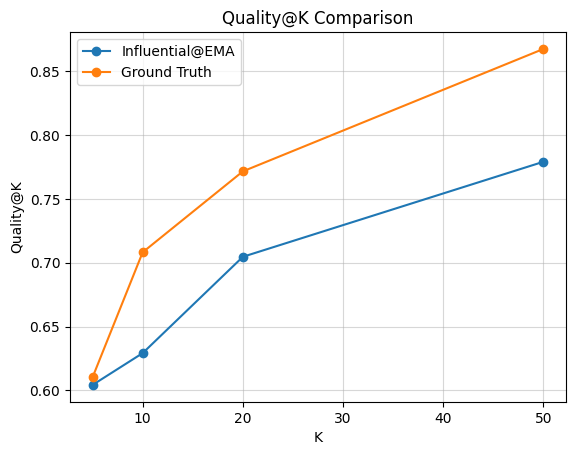

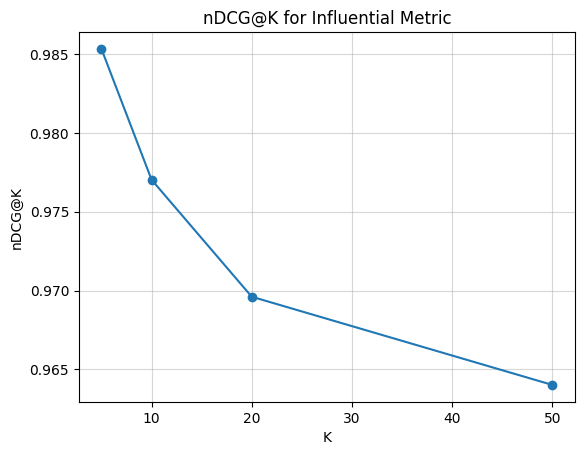

In [41]:
# --- 8. Results & Visualization ---
results = pd.DataFrame({
    'K': Ks,
    'Quality_pred': [quality_pred[K] for K in Ks],
    'Quality_truth': [quality_truth[K] for K in Ks],
    'nDCG': [ndcg_pred[K] for K in Ks]
})
print(results)

plt.figure()
plt.plot(results['K'], results['Quality_pred'], label='Influential@EMA', marker='o')
plt.plot(results['K'], results['Quality_truth'], label='Ground Truth', marker='o')
plt.xlabel('K'); plt.ylabel('Quality@K')
plt.grid(True, alpha=0.5)
plt.title('Quality@K Comparison'); plt.legend(); plt.show()

plt.figure()
plt.plot(results['K'], results['nDCG'], marker='o')
plt.xlabel('K'); plt.ylabel('nDCG@K')
plt.grid(True, alpha=0.5)
plt.title('nDCG@K for Influential Metric'); plt.show()